In [1]:
import warnings
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

SEED = 42
MAX_EPISODE = 5000
MAX_STEPS_PER_EPISODE = 1000
GAMMA = 0.99
EPS = 1e-8

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def get_reinforce_model(input_shape, output_shape, hidden_size):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(hidden_size, activation='relu')(inputs)
    output = layers.Dense(output_shape, activation='softmax')(x)

    return keras.Model(inputs=inputs, outputs=output)

In [3]:
# env = gym.make("CartPole-v1") 
env = gym.make("LunarLander-v2")

state_length = env.observation_space.shape[0]
n_actions = env.action_space.n

reinforce_network = get_reinforce_model(input_shape=state_length,
                                        output_shape=n_actions,
                                        hidden_size=32
)
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)
loss_fn = keras.losses.Huber()

action_log_probs = []
rewards = []
episode_rewards = []
running_rewards = []
running_reward = 0

for episode in range(1, MAX_EPISODE+1):
    state, _ = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for t in range(1, MAX_STEPS_PER_EPISODE+1):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            
            actions_prob = reinforce_network(state)
            action = np.random.choice(n_actions, p=np.squeeze(actions_prob))
            action_log_probs.append(tf.math.log(actions_prob[0, action]))
        
            state, reward, done, _, _ = env.step(action)
            
            rewards.append(reward)
            episode_reward += reward
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        running_rewards.append(running_reward)

        G = 0
        returns = deque(maxlen=len(rewards))
        for r in rewards[::-1]:
            G = r + GAMMA * G
            returns.appendleft(G)

        # standardize the 
        returns = np.array(returns)
        returns = (returns - returns.mean()) / (returns.std() + EPS)

        policy_loss = []
        for log_prob, ret in zip(action_log_probs, returns):
            policy_loss.append(-log_prob * ret)
        
        # Backpropagation
        loss = sum(policy_loss)
        grads = tape.gradient(loss, reinforce_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, reinforce_network.trainable_variables))

    # Clear the loss and reward history
    action_log_probs.clear()
    rewards.clear()
    
    if episode % 50 == 0:
        print(f"Reward at {episode} episode: {running_reward:.2f}")
        
    if running_reward > 200: #termination condition
        print(f"Solved at episode {episode}: running_reward={running_reward:.2f}")
        break

reinforce_network.save_weights("checkpoints/rnf_lunarlander.h5")

Reward at 50 episode: -185.04
Reward at 100 episode: -133.27
Reward at 150 episode: -122.74
Reward at 200 episode: -107.93
Reward at 250 episode: -38.25
Reward at 300 episode: -72.28
Reward at 350 episode: -48.30
Reward at 400 episode: -33.04
Reward at 450 episode: -25.99
Reward at 500 episode: -18.28
Reward at 550 episode: 7.13
Reward at 600 episode: 14.50
Reward at 650 episode: -3.60
Reward at 700 episode: 37.69
Reward at 750 episode: 23.72
Reward at 800 episode: 42.53
Reward at 850 episode: -2.04
Reward at 900 episode: 83.90
Reward at 950 episode: 93.76
Reward at 1000 episode: 103.18
Reward at 1050 episode: 17.01
Reward at 1100 episode: 7.41
Reward at 1150 episode: 11.72
Reward at 1200 episode: -14.10
Reward at 1250 episode: -44.94
Reward at 1300 episode: 6.95
Reward at 1350 episode: 115.11
Reward at 1400 episode: 114.59
Reward at 1450 episode: 101.45
Reward at 1500 episode: 100.79
Reward at 1550 episode: 5.30
Reward at 1600 episode: -121.00
Reward at 1650 episode: -12.15
Reward at 

KeyboardInterrupt: 

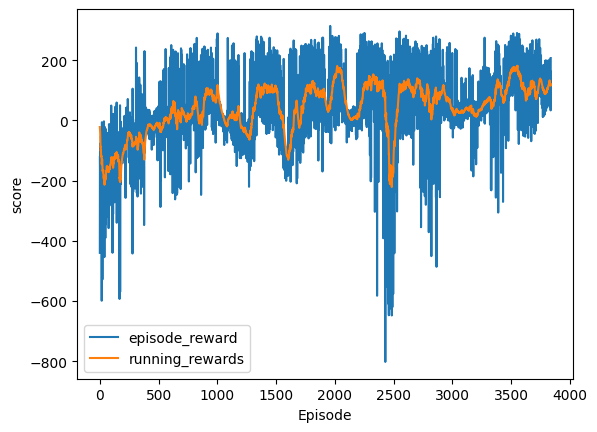

In [4]:
plt.plot(episode_rewards, label='episode_reward')
plt.plot(running_rewards, label='running_rewards')
plt.ylabel('score')
plt.xlabel('Episode')
plt.legend()
plt.show()